In [2]:
# 1. Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Import data
data = pd.read_pickle('../data/connectivity_compliance_matrices.pkl')
data.rename(columns={'ρ':'rho'}, inplace=True)
# Calculate mean of E1, E2, E3
data['mean_E'] = data[['E1', 'E2', 'E3']].mean(axis=1)
# Extract relevant features
X = data[['connectivity_matrix', 'compliance_matrix', 'rho', 'mean_E']]
display(X.head())


/Users/riya/anaconda3/envs/msse-python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,connectivity_matrix,compliance_matrix,rho,mean_E
0,"[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[16.2442166588418, -4.390589663678543, -4.392...",0.3,0.061528
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22.194443522542244, -7.184492662134119, -7.1...",0.3,0.045108
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[21.44865815819801, -6.467827160497426, -6.44...",0.3,0.046636
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15.247634909853652, -3.931170890685161, -3.9...",0.3,0.065567
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[23.16273271145176, -5.511611078765939, -5.66...",0.3,0.043226


In [2]:
# 2. Graph Construction Utilities

def construct_graph_data(row):
    conn_mat = row['connectivity_matrix']
    C_mat = row['compliance_matrix']
    rho = row['rho']
    mean_E = row['mean_E']

    min_val = np.min(C_mat)
    max_val = np.max(C_mat)
    C_mat = (C_mat - min_val) / (max_val - min_val)

    edge_index = np.array(np.nonzero(conn_mat)).T
    num_nodes = conn_mat.shape[0]
    rhos = np.array([rho] * num_nodes)
    num_neighbors = np.sum(conn_mat, axis=1)
    x = torch.tensor(np.column_stack((rhos, num_neighbors)), dtype=torch.float)
    graph_data = Data(
        x=x,
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
        y=torch.tensor(C_mat.flatten(), dtype=torch.float32),
        mean_E=torch.tensor([mean_E], dtype=torch.float32)
    )
    return graph_data

# Preview individual sample/edge matrix
sample = X.iloc[0]
conn_mat = sample['connectivity_matrix']
C_mat = sample['compliance_matrix']
edge_index = np.array(np.nonzero(conn_mat)).T
rho = sample['rho']
display(sample['connectivity_matrix'])
sample_data = Data(edge_index=torch.tensor(edge_index, dtype=torch.long), y=torch.tensor(C_mat, dtype=torch.float32))
print(f"Edge index:\n{sample_data.edge_index}")
print(f"Compliance matrix:\n{sample_data.y}")


array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]])

Edge index:
tensor([[ 0,  1],
        [ 0,  4],
        [ 1,  0],
        [ 1,  7],
        [ 2,  3],
        [ 2, 10],
        [ 3,  2],
        [ 3,  4],
        [ 4,  0],
        [ 4,  3],
        [ 4,  6],
        [ 4, 10],
        [ 6,  4],
        [ 6,  6],
        [ 7,  1],
        [ 7,  7],
        [10,  2],
        [10,  4]])
Compliance matrix:
tensor([[16.2442, -4.3906, -4.3921,  0.0000,  0.0000,  0.0000],
        [-4.3906, 16.2539, -4.3922,  0.0000,  0.0000,  0.0000],
        [-4.3921, -4.3922, 16.2602,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 38.9590,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 39.0762,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 39.0137]])


In [3]:
# 3. Build Graph Dataset & Print Stats

graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")

train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

num_node_features = int(train_data[0].x.shape[1])  # features per node
output_dim = int(train_data[0].y.shape[0])        # flattened compliance matrix length
num_nodes = int(np.sqrt(output_dim))
print(f"Node features per node: {num_node_features}")
print(f"Number of nodes per graph (sqrt of output dim): {num_nodes}")
print(f"Output dim (flattened compliance matrix): {output_dim}")


Constructed 2624 graph data objects.
Training set size: 2099
Testing set size: 525
len(y) per graph = 36
Data(x=[11, 2], edge_index=[2, 21], y=[36], mean_E=[1])
Node features per node: 2
Number of nodes per graph (sqrt of output dim): 6
Output dim (flattened compliance matrix): 36


In [4]:
# 4. GNN Model Definition

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

embedding_size = 64  # not strictly used

class GNN_v1(torch.nn.Module):
    """Graph-level regressor: N×GCNConv + configurable DNN."""
    def __init__(
        self,
        in_channels,
        embedding_size=128,
        out_dim=36,
        dropout=0.0,
        mlp_layers=1,
        hidden_neurons=64,
        num_convs=1,
        conv_channels=None
    ):
        super(GNN_v1, self).__init__()
        torch.manual_seed(42)
        if conv_channels is not None:
            widths = list(map(int, conv_channels))
            assert len(widths) >= 1, "conv_channels must have at least one width"
        else:
            widths = [int(embedding_size)] * max(int(num_convs), 1)
        convs = []
        in_c = in_channels
        for w in widths:
            convs.append(GCNConv(in_c, w))
            in_c = w
        self.convs = torch.nn.ModuleList(convs)
        self.dropout = Dropout(dropout)
        last_embed = widths[-1]
        d_in = last_embed * 2  # concat of [gmp, gap]
        hdim = last_embed if hidden_neurons is None else int(hidden_neurons)
        layers = []
        if mlp_layers <= 0:
            layers.append(Linear(d_in, out_dim))
        else:
            layers += [Linear(d_in, hdim), torch.nn.ReLU(), Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [Linear(hdim, hdim), torch.nn.ReLU(), Dropout(dropout)]
            layers.append(Linear(hdim, out_dim))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        h = x
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.relu(h)
        hg = torch.cat([gmp(h, batch), gap(h, batch)], dim=1)
        hg = self.dropout(hg)
        out = self.mlp(hg)  # [batch_size, out_dim]
        return out


In [6]:
import math
import torch
from torch import nn

class MultiHeadGraphAttention(nn.Module):
    """
    Multi-head self-attention over nodes, masked by adjacency matrix.

    X: [B, N, F_in]
    A: [B, N, N]  (0/1; 1 means "can attend")
    returns: [B, N, F_out]
    """
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super().__init__()
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.d_k = out_dim // num_heads

        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)

        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, A):
        # X: [B, N, F_in], A: [B, N, N]
        B, N, _ = X.shape

        Q = self.W_q(X)  # [B, N, out_dim]
        K = self.W_k(X)
        V = self.W_v(X)

        h = self.num_heads
        d_k = self.d_k

        # [B, N, out_dim] -> [B, h, N, d_k]
        Q = Q.view(B, N, h, d_k).transpose(1, 2)
        K = K.view(B, N, h, d_k).transpose(1, 2)
        V = V.view(B, N, h, d_k).transpose(1, 2)

        # attention scores: [B, h, N, N]
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        # adjacency mask: where A == 0, set score to -inf
        A_expanded = A.unsqueeze(1)  # [B, 1, N, N]
        mask = (A_expanded <= 0)
        scores = scores.masked_fill(mask, -1e9)

        attn = torch.softmax(scores, dim=-1)  # [B, h, N, N]
        attn = self.dropout(attn)

        # weighted sum of V: [B, h, N, d_k]
        out = torch.matmul(attn, V)

        # merge heads: [B, N, h * d_k]
        out = out.transpose(1, 2).contiguous().view(B, N, h * d_k)

        # final linear
        out = self.out_proj(out)  # [B, N, out_dim]
        return out


class GNN_v2_Attention(nn.Module):
    """
    Attention-enabled version of GNN_v1.

    Takes the same kind of PyG Data object (x, edge_index, batch),
    but replaces GCNConv with multi-head attention driven by the
    connectivity structure.
    """
    def __init__(
        self,
        in_channels,
        hidden_dim=64,
        out_dim=36,
        num_heads=4,
        num_layers=3,
        mlp_layers=1,
        hidden_neurons=64,
        dropout=0.0,
    ):
        super().__init__()
        torch.manual_seed(42)

        
        layers = []
        dim = in_channels
        for _ in range(num_layers):
            layers.append(
                MultiHeadGraphAttention(
                    in_dim=dim,
                    out_dim=hidden_dim,
                    num_heads=num_heads,
                    dropout=dropout,
                )
            )
            dim = hidden_dim
        self.att_layers = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # graph-level MLP head 
        d_in = hidden_dim 
        hdim = hidden_dim if hidden_neurons is None else int(hidden_neurons)
        layers = []
        if mlp_layers <= 0:
            layers.append(nn.Linear(d_in, out_dim))
        else:
            layers += [nn.Linear(d_in, hdim), nn.ReLU(), nn.Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [nn.Linear(hdim, hdim), nn.ReLU(), nn.Dropout(dropout)]
            layers.append(nn.Linear(hdim, out_dim))
        self.mlp = nn.Sequential(*layers)

    def _build_adj_per_graph(self, x, edge_index, batch):
        """
        Build dense adjacency matrices A_b for each graph b in the batch.

        Returns:
            A: [B, N_b, N_b] packed as a Python list of [N_b, N_b] tensors
            X_list: list of [N_b, F] node-feature tensors per graph
        """
        device = x.device
        num_graphs = int(batch.max().item()) + 1
        src, dst = edge_index

        A_list = []
        X_list = []

        for g in range(num_graphs):
            node_mask = (batch == g)
            idx = node_mask.nonzero(as_tuple=False).view(-1)  # global indices
            X_g = x[idx]  # [N_g, F]
            N_g = X_g.size(0)

            
            mapping = -torch.ones(x.size(0), dtype=torch.long, device=device)
            mapping[idx] = torch.arange(N_g, device=device)

            # edges within this graph
            edges_mask = node_mask[src] & node_mask[dst]
            src_local = mapping[src[edges_mask]]
            dst_local = mapping[dst[edges_mask]]

            A_g = torch.zeros(N_g, N_g, device=device)
            A_g[src_local, dst_local] = 1.0
            
            A_g.fill_diagonal_(1.0)

            A_list.append(A_g)
            X_list.append(X_g)

        return A_list, X_list

    def forward(self, data):
        """
        data: a batched PyG Data object with attributes:
            x: [N_total, F]
            edge_index: [2, E_total]
            batch: [N_total] graph ids
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # build per-graph adjacency + feature matrices
        A_list, X_list = self._build_adj_per_graph(x, edge_index, batch)

        graph_embs = []
        for A_g, X_g in zip(A_list, X_list):
            
            h = X_g.unsqueeze(0)
            A = A_g.unsqueeze(0)

            for att in self.att_layers:
                h = att(h, A)          # [1, N_g, hidden_dim]
                h = self.activation(h)
                h = self.dropout(h)

            # graph-level embedding mean over nodes
            g_emb = h.mean(dim=1)  # [1, hidden_dim]
            graph_embs.append(g_emb)

        # stack all graph embeddings in the batch: [B, hidden_dim]
        graph_emb = torch.cat(graph_embs, dim=0)

        # final MLP head to predict compliance entries
        out = self.mlp(graph_emb)  # [batch_size, out_dim]
        return out


Starting training...
Epoch 0 | Train MSE 0.093849
Epoch 5 | Train MSE 0.013261
Epoch 10 | Train MSE 0.011891
Epoch 15 | Train MSE 0.010930
Epoch 20 | Train MSE 0.010225
Epoch 25 | Train MSE 0.009945
Epoch 30 | Train MSE 0.009834
Epoch 35 | Train MSE 0.009540
Epoch 40 | Train MSE 0.009536
Epoch 45 | Train MSE 0.009386
Epoch 50 | Train MSE 0.009264
Epoch 55 | Train MSE 0.009138
Epoch 60 | Train MSE 0.009239
Epoch 65 | Train MSE 0.009097
Epoch 70 | Train MSE 0.009085
Epoch 75 | Train MSE 0.008991
Epoch 80 | Train MSE 0.008954
Epoch 85 | Train MSE 0.008906
Epoch 90 | Train MSE 0.008919
Epoch 95 | Train MSE 0.008922


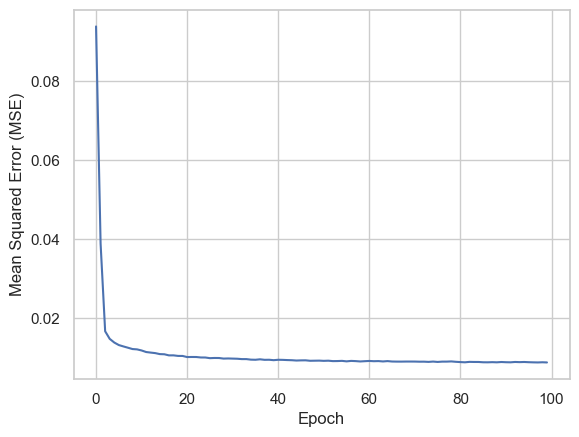

In [8]:
# 5. Training Setup and Loop - Modified Attention

from torch_geometric.data import DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GNN_v2_Attention(
    in_channels=num_node_features,
    hidden_dim=64,
    out_dim=output_dim,
    num_heads=4,
    num_layers=3,
    mlp_layers=1,
    hidden_neurons=64,
    dropout=0.1,
).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_GRAPHS_PER_BATCH = 32
train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

def train_epoch(loader):
    model.train()
    total_squared_error = 0.0
    total_elements = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view_as(pred).to(device)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()

        batch_se = F.mse_loss(pred, target, reduction='sum').item()
        total_squared_error += batch_se
        total_elements += pred.numel()
    return total_squared_error / total_elements if total_elements > 0 else float('nan')

print("Starting training...")
losses = []
EPOCHS = 100
for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Train MSE {train_loss:.6f}")

sns.set(style="whitegrid")
ax = sns.lineplot(x=list(range(len(losses))), y=losses)
ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
plt.show()


Starting training...
Epoch 0 | Train MSE 0.117259
Epoch 5 | Train MSE 0.010322
Epoch 10 | Train MSE 0.009646
Epoch 15 | Train MSE 0.009471
Epoch 20 | Train MSE 0.009302
Epoch 25 | Train MSE 0.009124
Epoch 30 | Train MSE 0.009003
Epoch 35 | Train MSE 0.008869
Epoch 40 | Train MSE 0.008775
Epoch 45 | Train MSE 0.008699
Epoch 50 | Train MSE 0.008636
Epoch 55 | Train MSE 0.008573
Epoch 60 | Train MSE 0.008541
Epoch 65 | Train MSE 0.008516
Epoch 70 | Train MSE 0.008505
Epoch 75 | Train MSE 0.008496
Epoch 80 | Train MSE 0.008486
Epoch 85 | Train MSE 0.008462
Epoch 90 | Train MSE 0.008451
Epoch 95 | Train MSE 0.008443


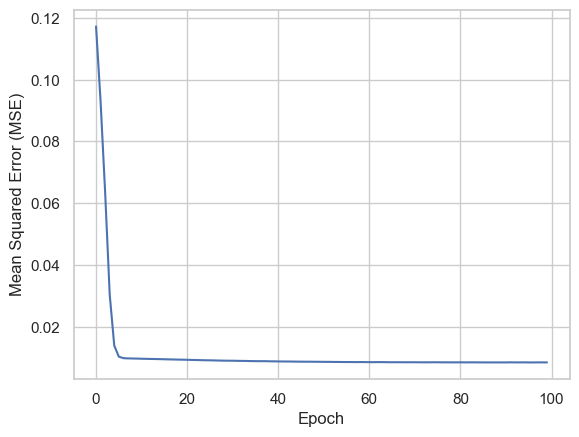

In [5]:
# 5. Training Setup and Loop

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

model = GNN_v1(
    in_channels=num_node_features,
    embedding_size=128,
    out_dim=output_dim,
    dropout=0.0,
    mlp_layers=1,
    hidden_neurons=64,
    num_convs=1
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

NUM_GRAPHS_PER_BATCH = 32
train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

def train_epoch(loader):
    model.train()
    total_squared_error = 0.0
    total_elements = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        target = batch.y.view_as(pred).to(device)
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        batch_se = F.mse_loss(pred, target, reduction='sum').item()
        total_squared_error += batch_se
        total_elements += pred.numel()
    return total_squared_error / total_elements if total_elements > 0 else float('nan')

print("Starting training...")
losses = []
EPOCHS = 100
for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Train MSE {train_loss:.6f}")

# Training loss plot
sns.set(style="whitegrid")
loss_indices = list(range(len(losses)))
ax = sns.lineplot(x=loss_indices, y=losses)
ax.set(xlabel="Epoch", ylabel="Mean Squared Error (MSE)")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

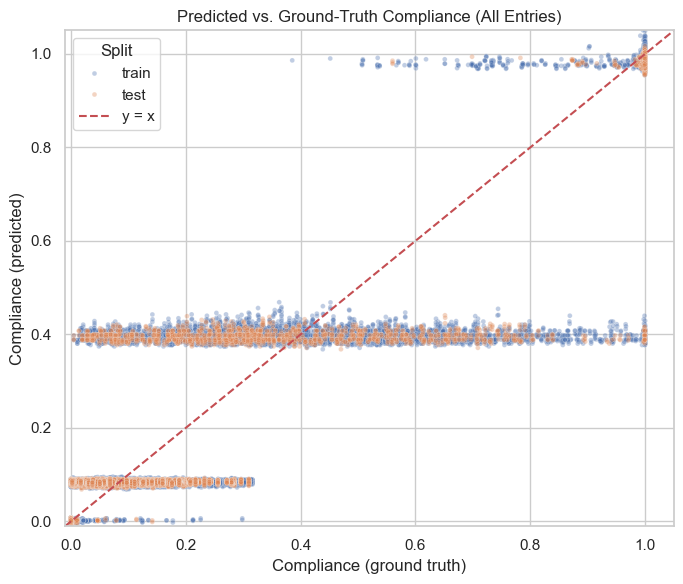

In [6]:
# 6. Evaluation and Prediction Plotting

def evaluate_split(loader, split_name, model, device):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)                     # [B, out_dim]
            target = batch.y.view_as(pred)          # [B, out_dim]
            p = pred.detach().cpu().numpy().ravel()
            t = target.detach().cpu().numpy().ravel()
            ys.append(t)
            preds.append(p)
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "split": split_name
    })
    return df

train_df = evaluate_split(train_loader, "train", model, device)
test_df  = evaluate_split(test_loader,  "test",  model, device)
comb_df  = pd.concat([train_df, test_df], ignore_index=True)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(
    data=comb_df,
    x="y_true",
    y="y_pred",
    hue="split",
    alpha=0.35,
    s=12,
    ax=ax
)
xy_min = float(min(comb_df["y_true"].min(), comb_df["y_pred"].min()))
xy_max = float(max(comb_df["y_true"].max(), comb_df["y_pred"].max()))
ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.5, label="y = x")
ax.set_xlim(xy_min, xy_max)
ax.set_ylim(xy_min, xy_max)
ax.set_xlabel("Compliance (ground truth)")
ax.set_ylabel("Compliance (predicted)")
ax.legend(title="Split")
ax.set_title("Predicted vs. Ground-Truth Compliance (All Entries)")
plt.tight_layout()
plt.show


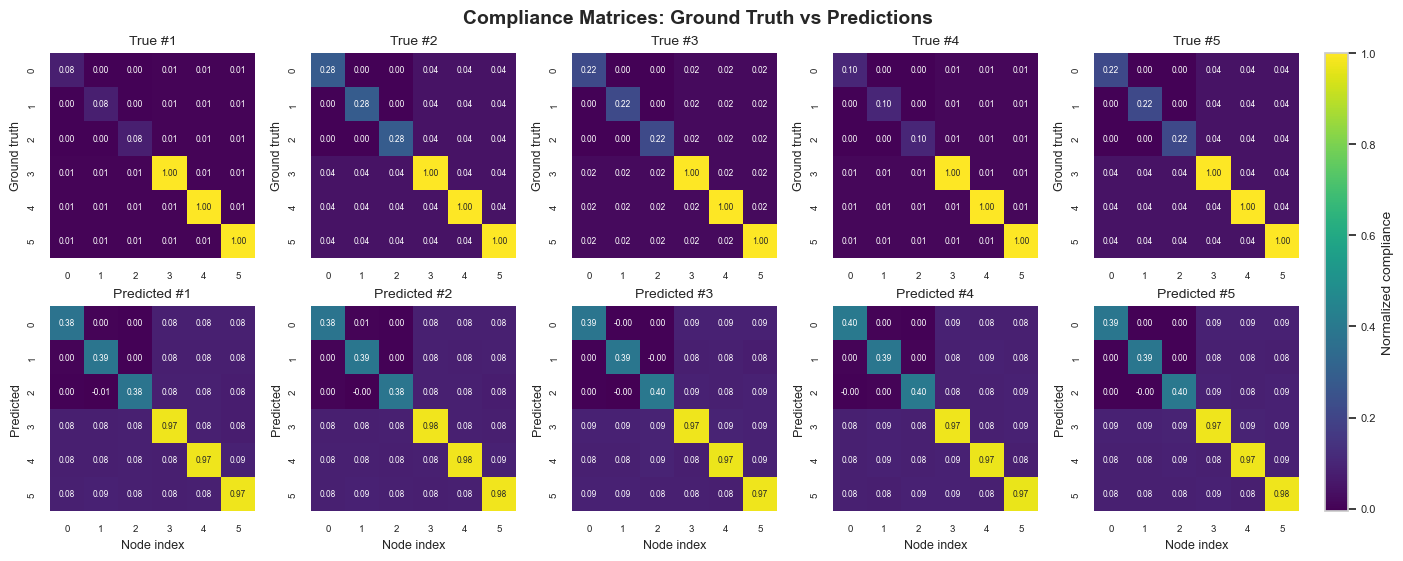

In [10]:
# 7. Visualize Predicted vs True Compliance Matrices (5 examples)

from torch_geometric.data import Batch  # add this import if not already present

def visualize_compliance_matrices(
    model,
    dataset,
    device,
    num_examples=5,
    annot=True,
    fmt=".2f"
):
    """
    Sample `num_examples` graphs from `dataset` and plot
    ground-truth vs predicted compliance matrices as heatmaps.
    Set annot=False for faster plotting (no numbers in cells).
    """
    model.eval()

    if len(dataset) == 0:
        print("Dataset is empty; nothing to visualize.")
        return

    # Choose up to num_examples unique random indices from the dataset
    num_examples = min(num_examples, len(dataset))
    indices = np.random.choice(len(dataset), size=num_examples, replace=False)
    samples = [dataset[i] for i in indices]

    # Build one batched graph so we only do a single forward pass
    batch = Batch.from_data_list(samples).to(device)

    with torch.no_grad():
        # Forward pass: [num_examples, out_dim]
        pred_all = model(batch).cpu().numpy()

    # Collect true and predicted matrices
    true_mats = []
    pred_mats = []
    for i, data in enumerate(samples):
        true_mat = data.y.view(num_nodes, num_nodes).cpu().numpy()
        pred_mat = pred_all[i].reshape(num_nodes, num_nodes)
        true_mats.append(true_mat)
        pred_mats.append(pred_mat)

    # Compute shared color scale across all shown matrices
    all_vals = np.concatenate(
        [m.ravel() for m in (true_mats + pred_mats)]
    )
    vmin = all_vals.min()
    vmax = all_vals.max()

    # Create 2 x num_examples grid:
    # top row = ground truth, bottom row = predictions
    fig, axes = plt.subplots(
        2,
        num_examples,
        figsize=(2.8 * num_examples, 5.5),
        constrained_layout=True
    )

    # If num_examples == 1, axes will not be 2D; normalize API
    if num_examples == 1:
        axes = np.array(axes).reshape(2, 1)

    # For a single shared colorbar, keep a handle to one of the heatmaps
    im_for_cbar = None

    annot_kws = {"fontsize": 6} if annot else None

    for i, (true_mat, pred_mat) in enumerate(zip(true_mats, pred_mats)):
        ax_true = axes[0, i]
        ax_pred = axes[1, i]

        # Ground-truth heatmap
        im_true = sns.heatmap(
            true_mat,
            ax=ax_true,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=annot,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_true.set_title(f"True #{i+1}", fontsize=10)
        ax_true.set_xlabel("")
        ax_true.set_ylabel("Ground truth", fontsize=9)
        ax_true.tick_params(axis="both", labelsize=7)

        # Predicted heatmap
        im_pred = sns.heatmap(
            pred_mat,
            ax=ax_pred,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=annot,
            fmt=fmt,
            annot_kws=annot_kws,
            square=True,
            cbar=False
        )
        ax_pred.set_title(f"Predicted #{i+1}", fontsize=10)
        ax_pred.set_xlabel("Node index", fontsize=9)
        ax_pred.set_ylabel("Predicted", fontsize=9)
        ax_pred.tick_params(axis="both", labelsize=7)

        # Use the first heatmap as the mappable for the shared colorbar
        if im_for_cbar is None:
            im_for_cbar = im_true.collections[0]

    # Add one shared colorbar for all subplots
    cbar = fig.colorbar(
        im_for_cbar,
        ax=axes.ravel().tolist(),
        fraction=0.035,
        pad=0.02
    )
    cbar.set_label("Normalized compliance", fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    fig.suptitle(
        "Compliance Matrices: Ground Truth vs Predictions",
        fontsize=14,
        weight="bold"
    )
    plt.show()


# Call this after training to visualize 5 test examples
# For fastest plotting, set annot=False
visualize_compliance_matrices(model, test_data, device, num_examples=5, annot=True)
